In [1]:
!mkdir -p ~/.kaggle


## Project Title: Pneumonia Detection from Chest X-Rays Using Deep Learning
Objective:
The goal of this project is to develop a robust deep learning model capable of accurately classifying chest X-ray images as either "NORMAL" or "PNEUMONIA". Students will employ Convolutional Neural Networks (CNNs) to automatically detect pneumonia from medical imaging data. This project aims to demonstrate the practical application of image classification techniques in medical diagnostics, improve understanding of CNN architectures, and assess model performance through various evaluation metrics. Additionally, students will gain experience in data preprocessing, model training, and performance evaluation, with the potential for deploying the model in a user-friendly application.


In [2]:
!cp kaggle.json ~/.kaggle/

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:27<00:00, 90.0MB/s]


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import glob
import cv2
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, InputLayer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [8]:
train_path = '/content/chest-xray-pneumonia/chest_xray/train'
val_path = '/content/chest-xray-pneumonia/chest_xray/val'
test_path = '/content/chest-xray-pneumonia/chest_xray/test'

In [9]:
def get_images(path):
    X = []
    y = []
    for file in os.listdir(path):
        images = glob.glob(path + f'/{file}' + '/*')
        for image in images:
            image_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (150, 150))
            image_array = np.expand_dims(image_array, axis = -1)
            X.append(image_array)
            y.append(1 if file != 'NORMAL' else 0)
    return X, y

In [10]:
X_train, y_train = get_images(train_path)
X_val, y_val = get_images(val_path)
X_test, y_test = get_images(test_path)

<BarContainer object of 2 artists>

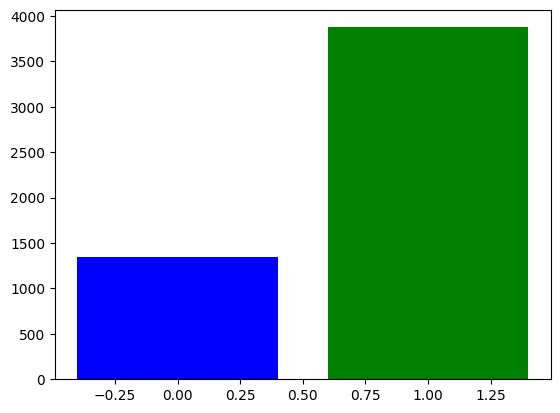

In [11]:
# Lets Show Data Balance Or Not
from collections import Counter
counts = Counter(y_train)
plt.bar(x = counts.keys(), height = counts.values(), color = ['b', 'g'])

Class is imbalance¶
## Build Model Wihtout handle class imbalance

In [12]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [13]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [14]:
data_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range = 30,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

data_gen.fit(X_train)

In [15]:
import tensorflow
tensorflow.keras.backend.clear_session()

In [16]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,033,601 (72.61 MB)

 Trainable params: 19,033,601 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history = model_1.fit(data_gen.flow(X_train,y_train,batch_size = 32)
                      ,epochs=5,
                      validation_data =(X_val, y_val))

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.8559 - loss: 0.3350 - val_accuracy: 0.6875 - val_loss: 0.7929
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.8922 - loss: 0.2483 - val_accuracy: 0.6250 - val_loss: 1.1546
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9040 - loss: 0.2331 - val_accuracy: 0.6875 - val_loss: 0.8443
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9176 - loss: 0.1927 - val_accuracy: 0.8125 - val_loss: 0.7315
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9256 - loss: 0.1793 - val_accuracy: 0.8125 - val_loss: 0.5864


In [23]:
y_pred = model_1.predict(X_test)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred])

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 762ms/step


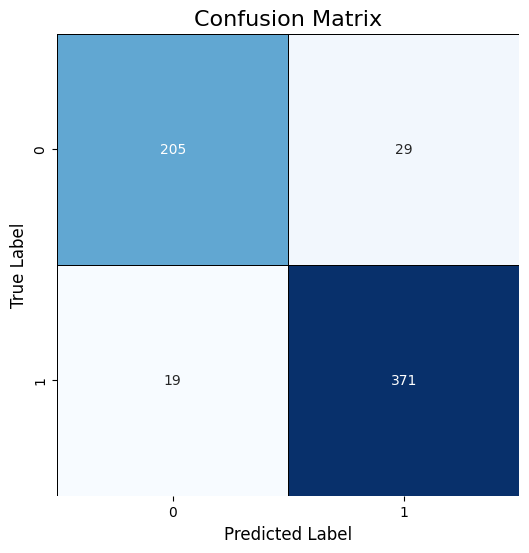

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       234
           1       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred))

In [25]:
# Lets Handle Imbalance Data Using Class Weights
from sklearn.utils import compute_class_weight
class_weights = dict(zip(np.unique(y_train), compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [26]:
model_2 = Sequential()
model_2.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 1)))
model_2.add(Conv2D(64, (3, 3), activation = 'relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(128, (3, 3), activation = 'relu'))
model_2.add(Conv2D(128, (3, 3), activation = 'relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(256, (3, 3), activation = 'relu'))
model_2.add(Conv2D(256, (3, 3), activation = 'relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Flatten())
model_2.add(Dense(256, activation = 'relu'))
model_2.add(Dense(1, activation = 'sigmoid'))
model_2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 146, 146, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 69, 69, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 30, 30, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,890,369 (60.62 MB)

 Trainable params: 15,890,369 (60.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
tensorflow.keras.backend.clear_session()
earlystopping = EarlyStopping(monitor='val_accuracy', patience = 3)
hist = model_2.fit(data_gen.flow(X_train, y_train, batch_size=32), epochs = 1, validation_data=(X_val, y_val), callbacks=[earlystopping])

163/163 ━━━━━━━━━━━━━━━━━━━━ 2189s 13s/step - accuracy: 0.7646 - loss: 0.4729 - val_accuracy: 0.8125 - val_loss: 0.6417


In [30]:
y_pred = model_2.predict(X_test)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred])

20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step


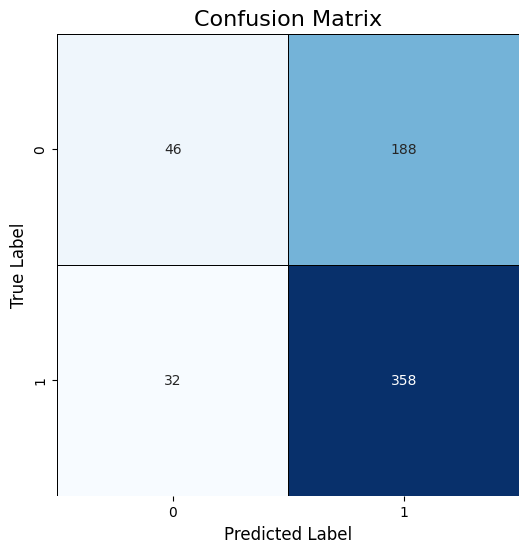

              precision    recall  f1-score   support

           0       0.59      0.20      0.29       234
           1       0.66      0.92      0.76       390

    accuracy                           0.65       624
   macro avg       0.62      0.56      0.53       624
weighted avg       0.63      0.65      0.59       624



In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred))

In [34]:
model_1.save('model_1.h5')
model_2.save('model_2.h5')

In [35]:

from keras.models import load_model
temp = load_model('model_1.h5')

In [36]:
temp.evaluate(X_test, y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step - accuracy: 0.8957 - loss: 0.3324


[0.24844443798065186, 0.9230769276618958]

In [37]:
# print versions of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import tensorflow as tf
import keras as kr
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv2.__version__)
print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)
print("keras version:", kr.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
OpenCV version: 4.10.0
scikit-learn version: 1.5.2
TensorFlow version: 2.17.0
keras version: 3.4.1


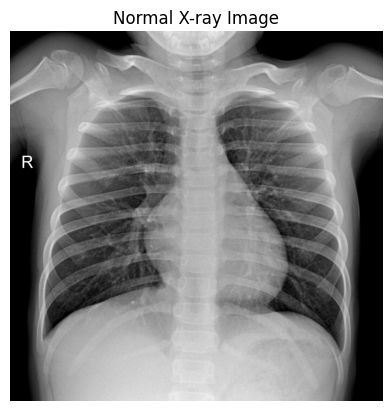

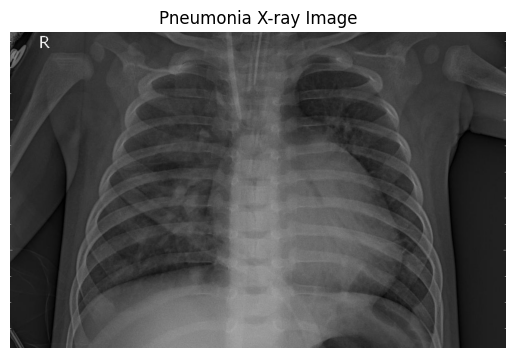

In [45]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the paths to the training dataset
train_normal_dir = '/content/chest-xray-pneumonia/chest_xray/train/NORMAL'  # Replace with actual path
train_pneumonia_dir = '/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'  # Replace with actual path

# Function to load and display an image
def display_image(image_path, title):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()

# Get a random normal image
normal_images = os.listdir(train_normal_dir)
normal_image_path = os.path.join(train_normal_dir, normal_images[0])  # Get the first normal image
display_image(normal_image_path, 'Normal X-ray Image')

# Get a random pneumonia image
pneumonia_images = os.listdir(train_pneumonia_dir)
pneumonia_image_path = os.path.join(train_pneumonia_dir, pneumonia_images[0])  # Get the first pneumonia image
display_image(pneumonia_image_path, 'Pneumonia X-ray Image')


In [46]:
from keras.models import load_model

# Load the model
loaded_model = load_model('model_1.h5')